# Image Deblurring with Plug-and-Play algorithms

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2425/tp8_pnp.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/><br/>

In this practical session, we will perform image deblurring by using several plug-and-play algorithms.

You should fill the regions
  `### TODO ###`

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

# default directory:
%cd /content/drive/MyDrive/Colab\ Notebooks
# # we advise to create a specific directory on your Google drive:
%cd /content/drive/MyDrive/genmod2425

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/genmod2425


In [2]:
import numpy as np
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import time
pi = torch.pi

print(torch.__version__)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

# !pip install bm3d
# !pip install deepinv
# or last version of deepinv:
!pip install git+https://github.com/deepinv/deepinv.git#egg=deepinv
!pip install pytorch-lightning
import deepinv as dinv

# Uncomment these two lines to download the files for this session
!wget https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
!unzip tp9.zip

%load_ext autoreload
%autoreload 2

2.6.0+cu124
cuda
  Cloning https://github.com/deepinv/deepinv.git to /tmp/pip-install-f409788c/deepinv_a3b774995f694a45a94590fd052f799f
  Running command git clone --filter=blob:none --quiet https://github.com/deepinv/deepinv.git /tmp/pip-install-f409788c/deepinv_a3b774995f694a45a94590fd052f799f
  Resolved https://github.com/deepinv/deepinv.git to commit 4bf6ae3937618c990d496bc76da37c56f60e01f5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-03-19 21:28:14--  https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 501814458 (479M) [application/zip]
Saving to: ‘tp9.zip.5’

tp9.zip.5           100%[===================>] 478.57M  2

In [30]:
def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    rmse = np.sqrt(np.mean((np.array(uref.cpu())-np.array(ut.cpu()))**2))
    return 20*np.log10(M/rmse)

def tensor2im(x):
    return x.detach().cpu().permute(2,3,1,0).squeeze().clip(0,1)

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,vmin=0,vmax=1,z=2,order=0,titre='',displayfilename=False):
    # By default, values are scaled with black=0 and white=1
    # In order to adapt the dynamics to the image, enter vmin and vmax as None
    im = im.detach().cpu().permute(2,3,1,0).squeeze()
    imin= np.array(im).astype(np.float32)
    channel_axis = 2 if len(im.shape)>2 else None
    imin = rescale(imin, z, order=order, channel_axis=channel_axis)
    if normalize:
        if vmin is None:
            vmin = imin.min()
        if vmax is None:
            vmax = imin.max()
        if np.abs(vmax-vmin)>1e-10:
            imin = (imin.clip(vmin,vmax)-vmin)/(vmax-vmin)
        else:
            imin = vmin
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))


# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

<br/><br/><br/>

# Setup: Define the Degradation Model

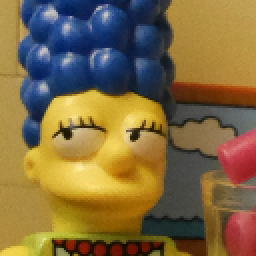

In [31]:
# Open the image
x0 = torch.tensor(plt.imread('im/simpson512crop.png'),device=device)
# x0 = torch.tensor(plt.imread('im/parrots.png'),device=device); x0 = x0[100:356,370:626,:]
# x0 = torch.tensor(plt.imread('im/marge2.png'),device=device)
# x0 = torch.tensor(plt.imread('im/simpson512.png'),device=device)
M,N,C = x0.shape
# Permute dimensions to fit tensor convention
x0 = x0.permute(2,0,1).unsqueeze(0)

viewimage(x0)

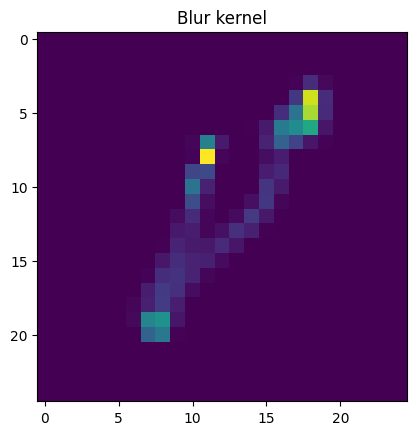

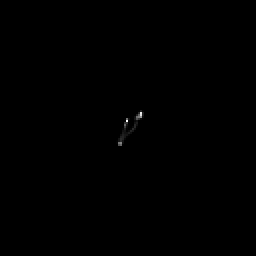

In [32]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxNx3 image, and put center at pixel (0,0)
k = torch.zeros((M,N),device=device)
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
k = k[None,None,:,:]
fk = fft2(k)

viewimage(fftshift(k),vmin=None,vmax=None)

Implement the forward model
$$ y = A(x_0) + \xi $$
where $\xi \sim \mathcal{N}(0,\nu^2 \mathsf{Id})$.
Write functions implementing the operator $A(x)$ and the corresponding data-fidelity term
$$f(x) = \frac{1}{2\nu^2} \|Ax-y\|_2^2 .$$

PSNR(x0,y) = 18.62


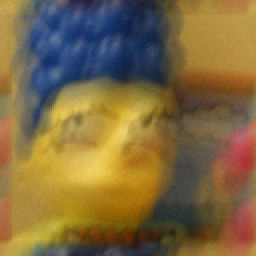

In [33]:
nu = .01  # noise level
torch.manual_seed(1)  # fix random seed for reproducibility

# Define corresponding operator and data-fidelity
def A(x):
    ### TODO ###
    return ifft2(fk * fft2(x)).real

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)

### TODO ###

y0 = A(x0)
y = y0 + nu * torch.randn_like(y0, device=device)

def f(x):
    ### TODO ###
    return 0.5 * torch.sum((A(x)-y)**2) / nu**2

print('PSNR(x0,y) = %.2f'%psnr(x0,y))

viewimage(y)

y# Exercise 1: PnP-PGD with off-the-shelf denoiser

In this exercise, we will solve image deblurring with the PnP-PGD algorithm:
$$ x_{k+1} = D_\sigma(x_k - \tau \nabla f(x_k)) .$$
where $f$ is the data-fidelity term, $\tau > 0$ is the step size, and where $D_\sigma$ is a pre-learned denoiser.

## Load and Test a pre-learned denoiser

In the following cell, we load a pre-learned denoiser thanks to the deepinv library.

Test this denoiser by denoising a noisy version of $x_0$:
$$ x_0 + w $$
where $w \sim \mathcal{N}(0,\nu^2 \mathsf{Id})$.

PSNR(x0,y) = 18.62


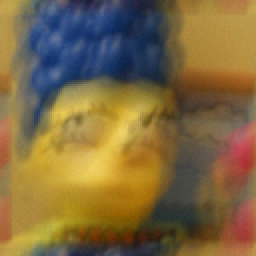

PSNR(x0,Dy) = 18.65


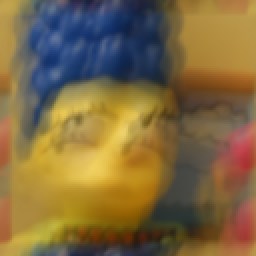

In [34]:
nu = 2/255 # 0.15

# Load the DRUNet denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DRUNet.html
D = dinv.models.DRUNet(pretrained='ckpts/drunet_color.pth').to(device)

# Load the BM3D denoiser
# https://deepinv.github.io/deepinv/stubs/deepinv.models.BM3D.html
# D = dinv.models.BM3D().to(device)

# Load the DnCNN denoiser (WARNING: the proposed weights are only trained for noise level sigma = 2/255)
# https://deepinv.github.io/deepinv/stubs/deepinv.models.DnCNN.html
# D = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_color.pth').to(device)
# D = dinv.models.DnCNN(pretrained='ckpts/dncnn_sigma2_lipschitz_color.pth').to(device)

# TV denoiser (only in last version of deepinv)
# Dtv = dinv.models.TVDenoiser().to(device)
# def D(x,sigma):
#   return Dtv(x,ths=2*sigma**2)

# compute noisy image
### TODO ###

xnoisy = A(x0) + nu * torch.randn_like(x0, device=device)

print('PSNR(x0,y) = %.2f'%psnr(x0,xnoisy))
viewimage(xnoisy)

# compute denoised image

### TODO ###
Dx = D(xnoisy, sigma=nu).detach()

print('PSNR(x0,Dy) = %.2f'%psnr(x0,Dx))
viewimage(Dx)


## Image deblurring with PnP-PGD

In this question, we will perform deblurring with the PnP-PGD algorithm
$$ x_{k+1} = D_\sigma \circ (\operatorname{Id} - \tau \nabla f) (x_k) $$
where $f(x)$ is the data-fidelity term.

Recall that $\tau$ should be $< \frac{2}{L}$ (where $L$ is the Lipschitz constant of $\nabla f$). If we assume that $D_\sigma$ is averaged and that there is a fixed point, then convergence is guaranteed.

Complete the following cell progressively, in order to address the following points:
1. Implement the PnP-PGD algorithm, and display the deblurred image.
2. Track the evolution of the PSNR.
3. Track the evolution of the residual $r_n = \frac{\|x_n - x_{n-1}\|}{\|x_0\|}$.
4. Try to adjust the parameter $\tau$ (gradient step size / strength of data-fidelity).
5. Try to adjust the parameter $s$ (strength of the denoiser).


[   0/ 100] [0.00000 s] PSNR = 18.62
[  10/ 100] [0.25479 s] PSNR = 27.00


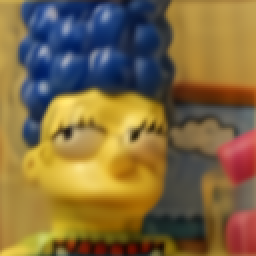

[  20/ 100] [0.42471 s] PSNR = 28.96


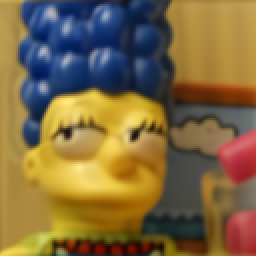

[  30/ 100] [0.59513 s] PSNR = 29.94


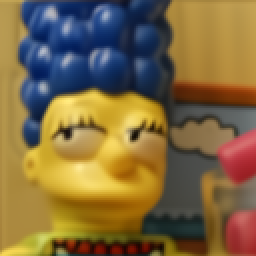

[  40/ 100] [0.76948 s] PSNR = 30.53


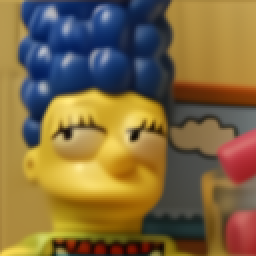

[  50/ 100] [0.93922 s] PSNR = 30.87


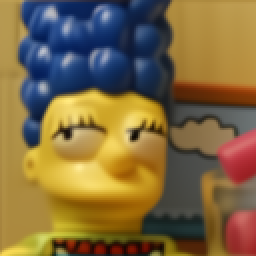

[  60/ 100] [1.10790 s] PSNR = 31.07


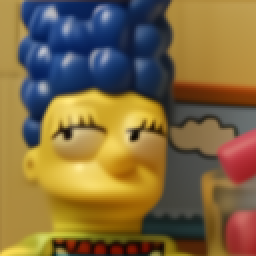

[  70/ 100] [1.27644 s] PSNR = 31.20


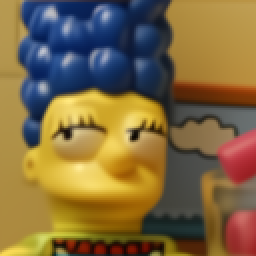

[  80/ 100] [1.44623 s] PSNR = 31.27


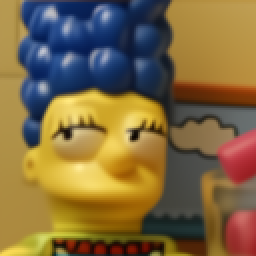

[  90/ 100] [1.61752 s] PSNR = 31.31


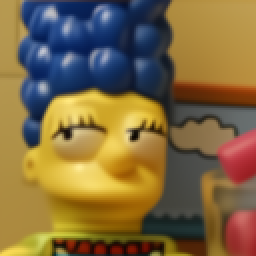

[ 100/ 100] [1.79216 s] PSNR = 31.34


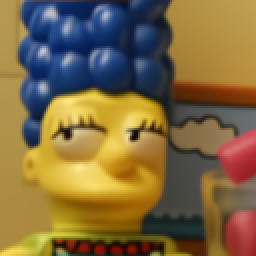

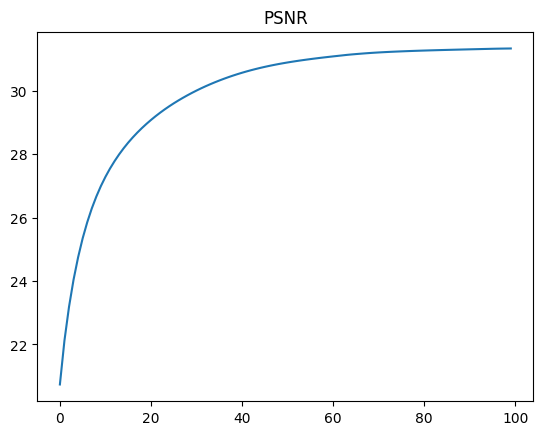

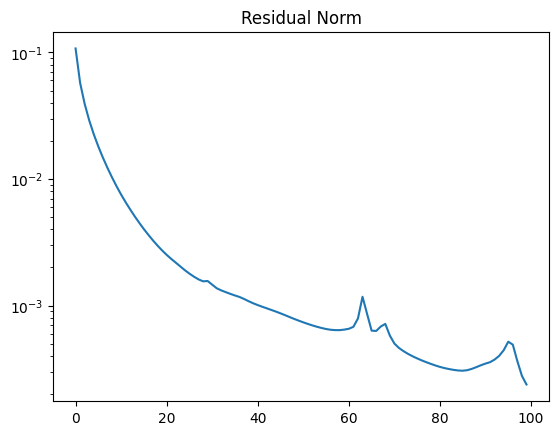

In [35]:
tau = 1.9*nu**2
s = 2*nu  # strength of the denoiser (corresponding to notation sigma)

# initialize
x = y.clone()
x.requires_grad_(True)
normxinit = torch.linalg.vector_norm(x)

psnrtab = []
rtab = []
vtab = []
niter = 100
t0 = time.time()

print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):
    ### TODO ###
    grad = torch.autograd.grad(f(x), x, create_graph=False, retain_graph=False)[0]

    with torch.no_grad():
      x_prev = x.clone()
      x -= tau * grad
      x = D(x, sigma=s)
    x.requires_grad_(True)

    rtab.append((torch.linalg.vector_norm(x - x_prev) / normxinit).detach().cpu())

    psnrt = psnr(x0, x.detach())
    psnrtab.append(psnrt)

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

# save results
xpgd = x.clone()

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.show()

In [36]:
# Use this cell to compare the behavior when using different denoisers
# psnrtabtmp = psnrtab.copy()
# rtabtmp = rtab.copy()
# vtabtmp = vtab.copy()
# rtab_pgd_bm3d = rtab.copy()
# psnrtab_pgd_bm3d = psnrtab.copy()
# vtab_pgd_bm3d = vtab.copy()
# rtab_pgd_drunet = rtab.copy()
# psnrtab_pgd_drunet = psnrtab.copy()
# vtab_pgd_drunet = vtab.copy()
# rtab_pgd_dncnn = rtab.copy()
# psnrtab_pgd_dncnn = psnrtab.copy()
# vtab_pgd_dncnn = vtab.copy()
# rtab_pgd_dncnnlip = rtab.copy()
# psnrtab_pgd_dncnnlip = psnrtab.copy()
# vtab_pgd_dncnnlip = vtab.copy()

Compare with explicit regularizations (Tychonov, smoothTV).

PSNR(x0,xtych) = 28.86


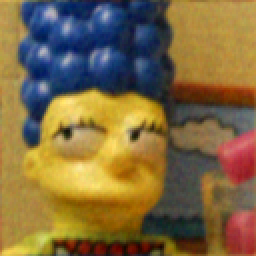

PSNR(x0,xtv) = 31.15


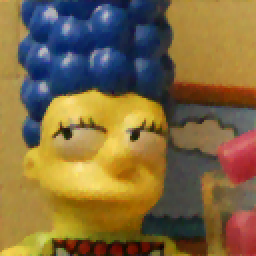

In [37]:
# Deblurring with Tychonov Regularization
def tych_deblur(y,k,lam=0.01):
    _,_,M,N = y.shape
    xi = torch.arange(M)
    ind = (xi>M/2)
    xi[ind] = xi[ind]-M
    zeta = torch.arange(N)
    ind = (zeta>N/2)
    zeta[ind] = zeta[ind]-N
    Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')
    Xi = Xi[None,None,:,:].to(device)
    Zeta = Zeta[None,None,:,:].to(device)
    fh = torch.conj(fk)/(torch.abs(fk)**2 + 8 * lam * (torch.sin(pi*Xi/M)**2 + torch.sin(pi*Zeta/N)**2))
    return ifft2(fft2(y)*fh).real

xtych = tych_deblur(y,k)

# Smooth TV regularization
def stv_deblur(A,y,xinit,niter=1000,lam=0.002,ep=0.01,lr=None):
    if lr is None:
        lr = 1.9/(1+lam*8/ep)
    x = xinit.clone().requires_grad_(True)
    optim = torch.optim.SGD([x], lr=lr)
    losslist = []
    for it in range(niter):
        d1 = torch.roll(x,-1,2) - x
        d2 = torch.roll(x,-1,3) - x
        reg = torch.sum(torch.sqrt(ep**2+d1**2+d2**2))
        loss = torch.sum((A(x)-y)**2) + lam*reg
        losslist.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    return x.detach(),losslist

xtv,losslist = stv_deblur(A,y,y.clone())
# plt.plot(losslist)
# plt.show()

# Display the results
print('PSNR(x0,xtych) = %.2f'%psnr(x0,xtych))
viewimage(xtych)
print('PSNR(x0,xtv) = %.2f'%psnr(x0,xtv))
viewimage(xtv)

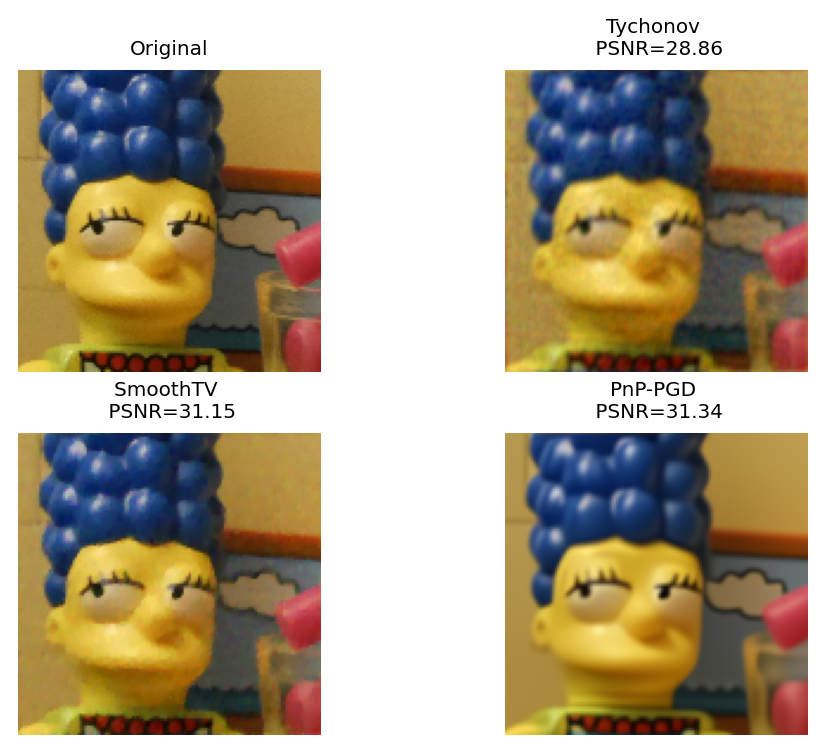

In [38]:
plt.figure(dpi=180)
plt.subplot(2,2,1)
plt.imshow(tensor2im(x0), cmap='gray')
plt.title('Original',fontsize=8)
# plt.imshow(tensor2im(y), cmap='gray')
# plt.title('Degraded \n PSNR='+str2(psnr(x0,y)),fontsize=8)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(tensor2im(xtych), cmap='gray')
plt.title('Tychonov \n PSNR='+str2(psnr(x0,xtych.detach())),fontsize=8)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(tensor2im(xtv), cmap='gray')
plt.title('SmoothTV \n PSNR='+str2(psnr(x0,xtv.detach())),fontsize=8)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(tensor2im(xpgd), cmap='gray')
plt.title('PnP-PGD \n PSNR='+str2(psnr(x0,xpgd.detach())),fontsize=8)
plt.axis('off')
plt.show()

In [39]:
# plt.figure(dpi=150)
# plt.semilogy(rtab_dncnn,label='DnCNN')
# plt.semilogy(rtab_dncnnlip,label='DnCNNLip')
# plt.semilogy(rtab_drunet,label='DRUNet')
# plt.semilogy(rtab_bm3d,label='BM3D')
# plt.legend() #(loc=1)
# plt.title('Residual Norm')
# plt.show()

# plt.figure(dpi=150)
# plt.plot(psnrtab_dncnn,label='DnCNN')
# plt.plot(psnrtab_dncnnlip,label='DnCNNLip')
# plt.plot(psnrtab_drunet,label='DRUNet')
# plt.plot(psnrtab_bm3d,label='BM3D')
# plt.plot([psnr(x0,xtv)]*niter,label='smoothTV')
# plt.plot([psnr(x0,xtych)]*niter,label='Tychonov')
# plt.legend()
# plt.title('PSNR')
# plt.show()

# plt.figure(dpi=150)
# plt.plot(vtab_dncnn,label='DnCNN')
# plt.plot(vtab_dncnnlip,label='DnCNNLip')
# plt.plot(vtab_drunet,label='DRUNet')
# plt.plot(vtab_bm3d,label='BM3D')
# plt.legend()
# plt.title('Denoiser Variations')
# plt.show()

# Exercise 2: PnP-PGD with Gradient-Step Denoiser

In this exercise, we will use PnP-PGD based on the gradient-step denoiser GS-DRUNet.

This amounts to using the PnP-PGD algorithm
$$ x_{k+1} = \mathsf{Prox}_{\tau f}\big(x_k - \tau  \lambda \nabla g_{\sigma}(x_k) \big) .$$
that aims at minimizing the functional
$$F(x) = f(x) + \lambda g_{\sigma}(x)$$
where $g_{\sigma}$ is the regularization function linked to the gradient-step denoiser.

Notice that we now need to access $\mathsf{Prox}_{\tau f}$.
<br/><br/>

Implement the proximal operator of the data-fidelity term.

In [40]:
def proxf(x,tau):
    ### TODO ###
    a = torch.conj(fk)*fft2(y)/nu**2 + fft2(x)/tau
    b = torch.abs(fk)**2 + 1/tau
    return ifft2(a/b).real

Load and test the gradient-step DRUNet denoiser.

For that, recall that the function $g_{\sigma}$ is accessible through `D.potential`, and the corresponding gradient-step denoiser then writes
$$ D_{\sigma} = \mathsf{Id} - \nabla g_{\sigma} .$$

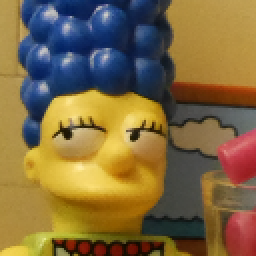

In [41]:
# torch.autograd.set_grad_enabled(True)
D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt').to(device)


### TODO ###
xnoisy = x0 + nu * torch.randn_like(x0, device=device)

# compute denoised image
Dxt = D(xnoisy,sigma=nu)

x = xnoisy.clone().contiguous().requires_grad_(True)
px = D.potential(x,sigma=nu)
grad = torch.autograd.grad(px, x, create_graph=False, retain_graph=False)[0]
Dxt = xnoisy - grad

viewimage(Dxt)

### PnP-PGD with Gradient-Step Denoiser with Backtracking

1) Implement the proximal gradient descent algorithm with gradient-step denoiser.

Along the iterations, track the function values $F(x_k)$, the PSNR and the residual norm $r_k = \frac{\|x_{k}-x_{k-1}\|}{\|x_0\|}$.

2) Modify your code so that the output image $\tilde{x}_k$ (variable `xvisu`) is the one obtained before the last proximal step:
$$ x_{k+1} = \mathsf{Prox}_{\tau f}(\tilde{x}_k) .$$
You may display `xvisu` instead of `x` and track PSNR with `xvisu`.
<!-- (In order to improve visual quality, it is useful not to apply the last data-fidelity step which adds back some noise.) <br/>
You may also display the value $F(\tilde{x}_k)$ which corresponds to values obtained by the HQS algorithm
$$ \tilde{x}_{k+1} = \tilde{D}_\sigma(\mathsf{Prox}_{\tau f}(\tilde{x}_k))$$
where $\tilde{D}_\sigma = \mathsf{Id} - \tau \lambda\nabla g_\sigma$ is (by abuse) seen here as a proximal regularization step.
 -->
3) Modify your code in order to include the backtracking procedure (recalled below).


We recall here the principle of backtracking.
Let us denote by
$$T_\tau(x_k) = \mathsf{Prox}_{\tau f}(x_k - \tau  \lambda \nabla g_{\sigma}(x_k))$$
the PnP-PGD update. At iteration $k$, the backtracking procedure launches the loop
$$ \textbf{while} \quad  F(x_k) - F(T_\tau(x_k)) < \frac{\gamma}{\tau} \|T_\tau(x_k) - x_k\|^2 \quad \textbf{do} \quad \tau \leftarrow \eta \tau .$$
Once this loop finishes, we can set $x_{k+1} = T_\tau(x_k)$.
You may take $\gamma = 0.4, \eta = 0.9$.

In [ ]:
from math import gamma
# GSDRUNET
# https://deepinv.github.io/deepinv/stubs/deepinv.models.GSDRUNet.html
# D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt', train=False).to(device)
D=dinv.models.GSDRUNet(pretrained='ckpts/GSDRUNet.ckpt').to(device)

# Parameters
tau = 2e-5
s = 1.8*nu  # strength of the denoiser
lam = 1600
gamma = 0.4
eta = 0.9

# Define the objective function
def F(x, lam):
    return lam*D.potential(x,sigma=s) + f(x)

# initialize
x = torch.clone(y).requires_grad_(True)
normxinit = torch.linalg.vector_norm(x.detach())
xvisuold = x.clone().detach()

losstab = []
psnrtab = []
rtab = []
losstab2 = []
psnrtab2 = []
rtab2 = []

niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))

for it in range(niter):

    ### TODO ###
    tau_it = tau

    T_x = proxf(x - tau_it * lam * torch.autograd.grad(D.potential(x,sigma=s), x, create_graph=False, retain_graph=False)[0],tau_it)
    while F(x, lam) - F(T_x, lam) < gamma / tau_it * torch.sum((T_x - x)**2):
        tau_it *= eta

    x = proxf(x, tau_it)

    if it%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnr(x0,x.detach())))
        viewimage(x)

# plt.plot(losstab)
# plt.title('$F(x_k)$')
# plt.legend()
# plt.show()

# plt.plot(psnrtab)
# plt.title('PSNR')
# plt.legend()
# plt.show()

# plt.semilogy(rtab)
# plt.title('Residual Norm')
# plt.legend()
# plt.show()

# # save results
# x_gspgd = x.detach().clone()
# losstab_gspgd = losstab.copy()
# psnrtab_gspgd = psnrtab.copy()
# rtab_gspgd = rtab.copy()

# # save results
# tmp_x_gspgd = x.detach().clone()
# tmp_losstab_gspgd = losstab.copy()
# tmp_psnrtab_gspgd = psnrtab.copy()
# tmp_rtab_gspgd = rtab.copy()

[   0/ 100] [0.00000 s] PSNR = 18.62


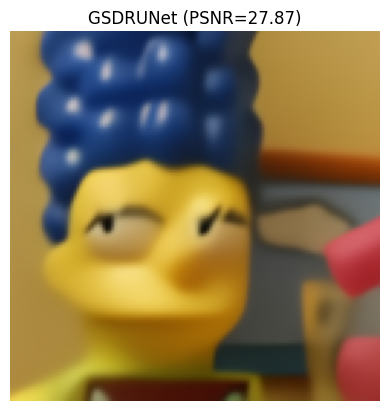

In [24]:

plt.title(f"GSDRUNet (PSNR={psnr(x0.detach(),x.detach()):.2f})")
plt.imshow(tensor2im(x.detach()), cmap='gray')
plt.axis('off')
plt.show()

# Exercise 3: Plug-and-Play with other splitting algorithms.

In this exercise, you will use Plug-and-Play algorithms based on the other splitting algorithms:
- half-quadratic splitting (HQS)
- Douglas-Rachford splitting (DRS)

## Image deblurring with PnP-HQS

Implement the PnP-HQS algorithm with an off-the-shelf denoiser:
$$ x_{k+1} = D_\sigma \circ \mathsf{Prox}_{\tau f} (x_k) .$$

In [ ]:
tau = 1.9*nu**2
s = 2*nu  # strength of the denoiser

# initialize
x = y.clone()
normxinit = torch.linalg.vector_norm(x)

psnrtab = []
rtab = []
vtab = []
niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))
for it in range(niter):

    ### TODO ###

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

xhqs = x.clone()
rtab_hqs = rtab.copy()
psnrtab_hqs = psnrtab.copy()

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.show()

plt.plot(vtab)
plt.title('Denoiser Variations')
plt.show()

## Image deblurring with PnP-DRS

Implement the PnP-DRS algorithm with an off-the-shelf denoiser :
$$ x_{k+1} = \left(\frac{1}{2} \mathsf{Id} + \frac{1}{2} (2 D_\sigma - \mathsf{Id}) \circ (2\mathsf{Prox}_{\tau f}-\mathsf{Id})\right) (x_k) .$$
Recall that the solution of the inverse problem is obtained after one proximal step
$$ \tilde{x}_k = \mathsf{Prox}_{\tau f} (x_k) .$$

In [ ]:
tau = 1.9*nu**2
s = 2*nu  # strength of the denoiser

# initialize
x = y.clone()
normxinit = torch.linalg.vector_norm(x)

psnrtab = []
rtab = []
niter = 100
t0 = time.time()
print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(0,niter,0,psnr(x0,y)))
for it in range(niter):

    ### TODO ###

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(xtilde)

xdrs = xtilde

rtab_hqs = rtab.copy()
psnrtab_hqs = psnrtab.copy()

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.show()

# Compare Results obtained with PGD, HQS, DRS

In [ ]:
plt.figure(dpi=150)
plt.semilogy(rtab_gspgd,label='PGD')
plt.semilogy(rtab_hqs,label='HQS')
plt.semilogy(rtab_drs,label='DRS')
plt.legend() #(loc=1)
plt.title('Residual Norm')
plt.show()

plt.figure(dpi=150)
plt.plot(psnrtab_gspgd,label='PGD')
plt.plot(psnrtab_hqs,label='HQS')
plt.plot(psnrtab_drs,label='DRS')
plt.plot([psnr(x0,xtv)]*niter,label='smoothTV')
plt.plot([psnr(x0,xtych)]*niter,label='Tychonov')
plt.legend()
plt.title('PSNR')
plt.show()

<br/><br/><br/>

# Exercise 4: Image super-resolution

Implement a PnP algorithm that addresses image deblurring with non-periodic boundary conditions.

You should adapt the codes of the previous exercises for super-resolution. The forward model for super-resolution involves an anti-aliasing filter whose Fourier transform is given in the next cell.

We advise you to make a copy of the whole notebook and to make the adaptation in a separate file.

In [ ]:
# Adjust the framework to address super-resolution with smoothed TV
# For anti-aliasing, you may use the Butterworth filter of order n and cut-off frequency fc
#   given below

# fc is the cut-off frequency normalized in (0,1)
def butterworth(M,N,fc=.5,order=20):
    xi = torch.arange(M)
    ind = (xi>M/2)
    xi[ind] = xi[ind]-M
    zeta = torch.arange(N)
    ind = (zeta>N/2)
    zeta[ind] = zeta[ind]-N
    Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')
    Xi = Xi[None,None,:,:].to(device)
    Zeta = Zeta[None,None,:,:].to(device)
    bf1 = 1/torch.sqrt(1+(Xi/(M*fc/2))**(2*order))
    bf2 = 1/torch.sqrt(1+(Zeta/(N*fc/2))**(2*order))
    return bf1*bf2

bf = butterworth(M,N)
viewimage(bf)

In [ ]:
nu = .01  # noise level
torch.manual_seed(1)  # fix random seed for reproducibility

# Define corresponding operator and data-fidelity
stride = 2  # downsampling factor
def A(x):
    ### TODO ###

def f(x):
    ### TODO ###

# Draw a sample of the direct model for image deblurring (apply blur and add Gaussian noise)
### TODO ###
viewimage(y)

In [ ]:
tau = 1.9*nu**2
s = 2*nu  # strength of the denoiser

# initialize
x = torch.ones_like(x0)
normxinit = torch.linalg.vector_norm(x)

psnrtab = []
rtab = []
vtab = []
niter = 100
t0 = time.time()
for it in range(niter):
    ### TODO ###

    if (it+1)%10==0:
        print('[%4d/%4d] [%.5f s] PSNR = %.2f'%(it+1,niter,time.time()-t0,psnrt))
        viewimage(x)

xpgd = x

plt.plot(psnrtab)
plt.title('PSNR')
plt.show()

plt.semilogy(rtab)
plt.title('Residual Norm')
plt.show()

plt.plot(vtab)
plt.title('Denoiser Variations')
plt.show()